## Improvements to make:

- negative binomial instead of poisson
- add season, player type, etc.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_SEED = 42

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.10.3


In [2]:
import pandas as pd

df = pd.read_csv("bayesdata.csv")

In [3]:
df.head()

,player_id,game_id,date,points,3_pointers,rebounds,assists,steals,blocks,turnovers
0,1630173,22300432,"DEC 29, 2023",0,0,2,0,0,0,0
1,1630173,22300416,"DEC 27, 2023",3,0,1,0,1,1,1
2,1630173,22300395,"DEC 23, 2023",8,0,2,1,0,2,0
3,1630173,22300382,"DEC 22, 2023",4,0,6,1,2,0,1
4,1630173,22300369,"DEC 20, 2023",13,1,5,1,1,1,1


<Axes: xlabel='points', ylabel='Count'>

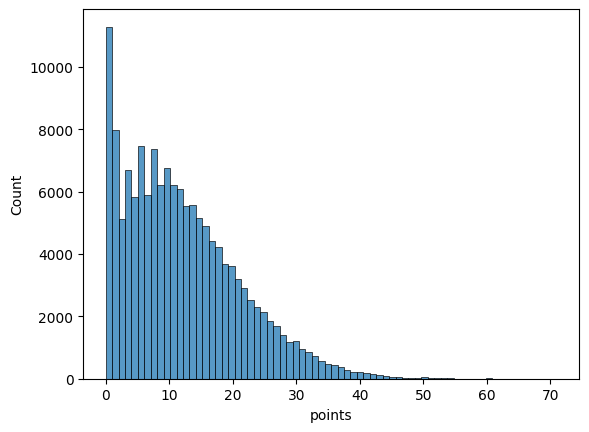

In [4]:
sns.histplot(
    x="points",
    data=df,
    bins=70,
)

In [5]:
points = df["points"].astype(int).values
coords = {"player": df.player_id.values}

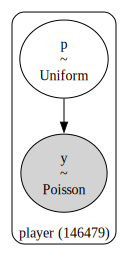

In [6]:
with pm.Model(coords=coords) as uninformative_prior_model:
    p = pm.Uniform("p", 0, 80, dims="player")

    y = pm.Poisson("y",  mu=p, observed=points, dims="player")

pm.model_to_graphviz(uninformative_prior_model)

In [7]:
with uninformative_prior_model:
    uninformed_prior_trace = pm.sample_prior_predictive(1000)

Sampling: [p, y]


<Axes: ylabel='Count'>

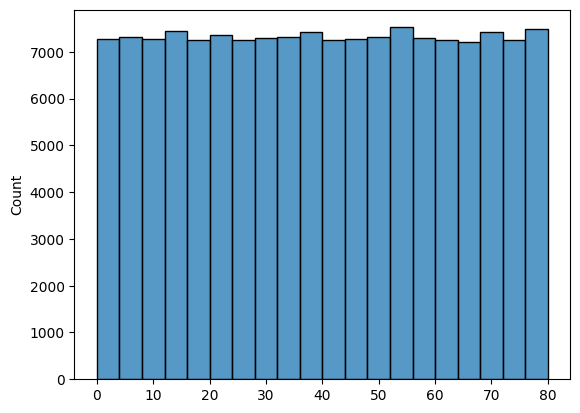

In [8]:
sns.histplot(
    uninformed_prior_trace.prior["p"].sel(chain=[0], draw=[0]).squeeze(), bins=20
)